Enter Cell to View: Chrna2-Cre_OE25;Ai14-351080.03.01.01


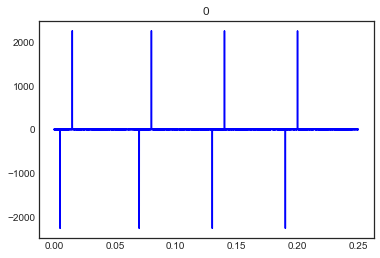

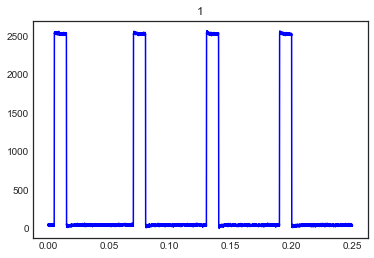

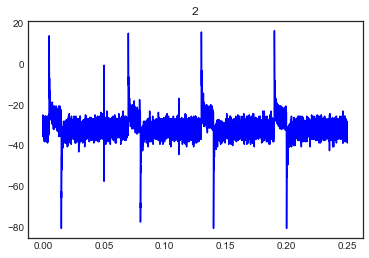

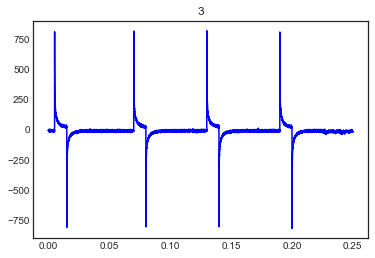

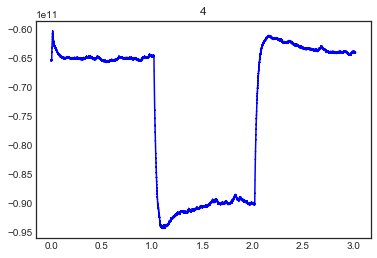

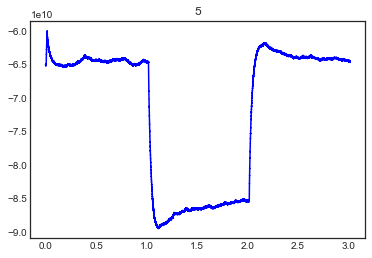

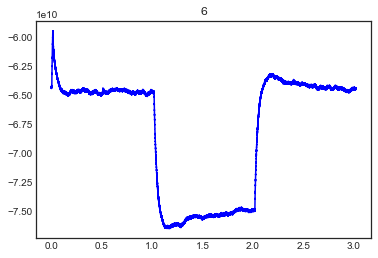

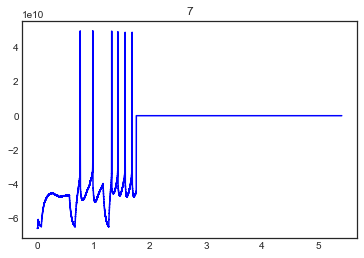

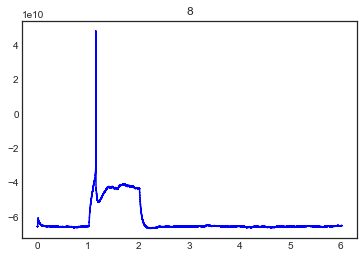

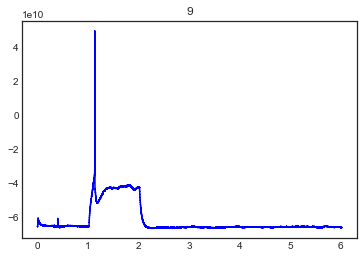

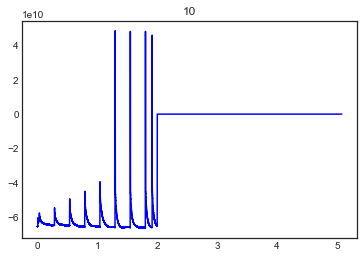

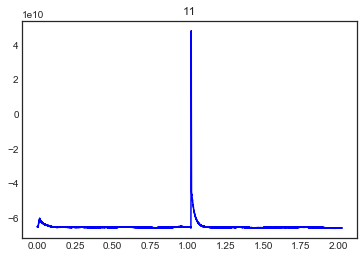

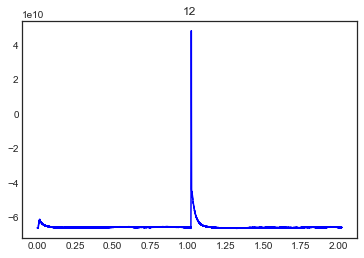

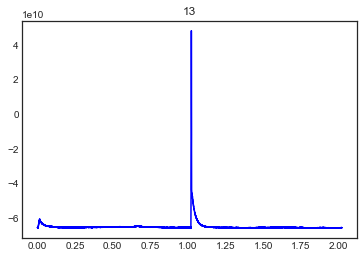

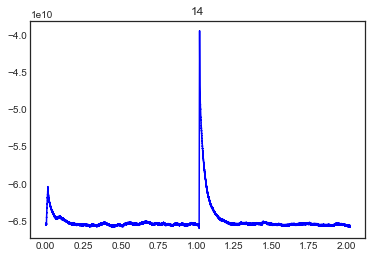

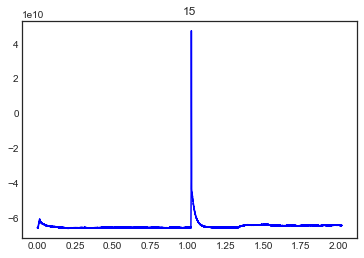

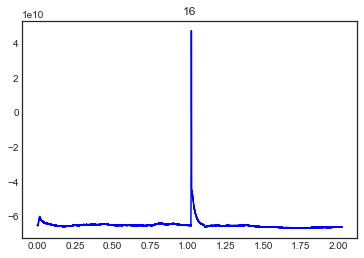

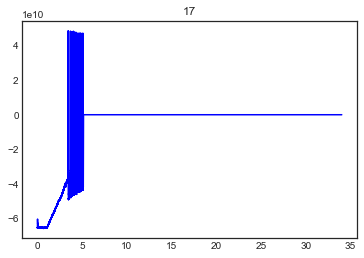

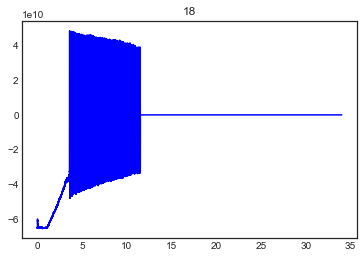

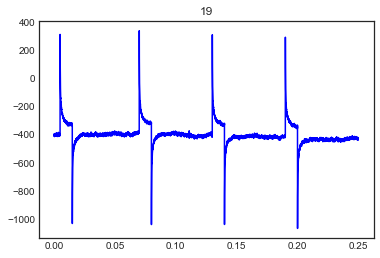

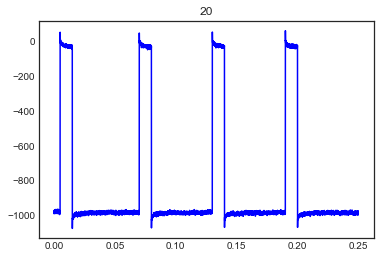

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from allensdk.core.nwb_data_set import NwbDataSet
import seaborn as sns
import pg8000
import os

sns.set_style('white')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

def nwb_linux(Linuxpath):
    #converts to linux path in LIMS to Windows path and adds the nwb
    
    SplitLinux = Linuxpath.split('/')
    try:
        return (r"\\" + os.path.join(SplitLinux[1], SplitLinux[2],SplitLinux[3],SplitLinux[4], SplitLinux[5],SplitLinux[6],SplitLinux[7],
                                     SplitLinux[7].split('_')[-1] + '.nwb'))
    except (WindowsError, AttributeError, IndexError):
        try:
            return (r"\\" + os.path.join('titan','cns', SplitLinux[2], SplitLinux[4],
                                         SplitLinux[5],SplitLinux[5].split('_')[-1] + '.nwb'))
        except (WindowsError, AttributeError, IndexError):
            return None
            print 'Could not find cell'
            
            
cell = raw_input('Enter Cell to View: ')

conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
cur = conn.cursor()

cur.execute("SELECT cell.id AS cell_id, cell.name AS cell_name, err.id AS roi_id, \
err.storage_directory AS path \
FROM specimens cell \
JOIN specimens slice ON cell.parent_id = slice.id \
JOIN ephys_roi_results err ON err.id = cell.ephys_roi_result_id \
WHERE cell.name ilike %s",(cell,))
result = cur.fetchone()

if result != None:
    nwb_path = nwb_linux(result[3])
    data = NwbDataSet(nwb_path)


    for sweep in sorted(data.get_sweep_numbers()):

        sweep_data = data.get_sweep(sweep)
        sampling_rate = sweep_data["sampling_rate"] # in Hz
        index_range = sweep_data["index_range"]
        i = sweep_data["stimulus"][0:index_range[1]+1] # in A
        v = sweep_data["response"][0:index_range[1]+1] # in V
        t = np.arange(0, len(v)) * (1.0 / sampling_rate)

        i *= 1e3 # to pA
        v *= 1e12 # to mV
        plt.figure()
        plt.plot(t,v, color = 'blue')
        plt.title(sweep)
if result == None:
    print 'could not find cell'

# View Individual Sweeps Here

Enter Sweep to View: 7


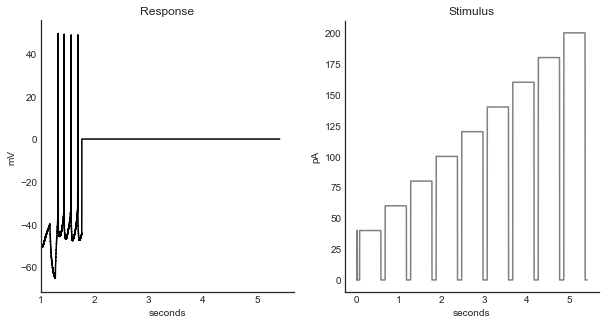

In [15]:
sweep = int(raw_input('Enter Sweep to View: '))
if sweep in data.get_sweep_numbers():
    sweep_data = data.get_sweep(sweep)
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    index_range = sweep_data["index_range"]
    i = sweep_data["stimulus"][0:index_range[1]+1] # in A
    v = sweep_data["response"][0:index_range[1]+1] # in V
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)

    i *= 1e12 # to pA
    v *= 1e3 # to mV
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

    ax1.plot(t, v, color='black')
    ax2.plot(t, i, color='gray')
    ax1.set_ylabel("mV")
    ax2.set_ylabel("pA")
    ax1.set_xlabel("seconds")
    ax2.set_xlabel("seconds")
    ax1.set_title('Response')
    ax2.set_title("Stimulus")
    
    ####fill in here as needed
    ax1.set_xlim(0,)
    
    
    
    sns.despine()
    plt.show()
    
else:
    print "I'm sorry. That sweep couldn't be found. Try another sweep"